In [97]:
#载入包

import numpy as np
import pandas as pd
import os
from pandas import Series,DataFrame
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import math
import datetime
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
import sklearn.metrics as sklm
from sklearn.metrics import confusion_matrix
import sklearn.cluster as sklc
import seaborn as sn
import scipy
import arcpy
import geopandas
from warnings import simplefilter

simplefilter(action='ignore', category=Warning)

%matplotlib inline

In [98]:
#数据清洗与整理
'''
1. 读取原始数据并删除无效行
2. 处理空值并定义部分文本
3. 将部分值以判断有无进行呈现(license_tf,host_location_tf)
4. 将部分值以定量方法进行呈现(host_verification_num,amenities_num)
5. 计算房东加入Airbnb的时间(host_duration)
6. 热门程度指数计算(pop_past,pop_future,popularity)
7. 删除无效变量
8. 输出清洗后数据
'''

#读取原始数据并删除无效行
listings_data = pd.read_csv('https://raw.githubusercontent.com/XianlaiYin/Data/main/listings.csv')
#drop columns and select points in Seattle
listings_data_1 = listings_data.drop(labels=['name','description','neighborhood_overview','neighbourhood','host_thumbnail_url','host_picture_url','picture_url','calendar_last_scraped','host_url','host_name','host_about','scrape_id', 'last_scraped', 'source', 'listing_url', 'host_neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'availability_60','availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count'], axis=1)
listings_seattle= listings_data_1.drop(listings_data_1[listings_data_1['has_availability'] == 'f'].index)
listings_seattle.reset_index(drop=True,inplace=True)

#处理空值并定义部分文本
listings_seattle['reviews_per_month'] = listings_seattle['reviews_per_month'].replace([np.nan],0)
listings_seattle['bathrooms_text'] = listings_seattle['bathrooms_text'].replace([np.nan],'0')
listings_seattle['bathrooms'] = listings_seattle['bathrooms_text'].str.split('\s+').str[0]
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('half-bath',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('Half-bath',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace('Shared',0.5)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].replace([np.nan],0)
listings_seattle['bathrooms'] = listings_seattle['bathrooms'].astype(float)
listings_seattle['bedrooms'] = listings_seattle['bedrooms'].replace([np.nan],0)
listings_seattle['host_location'] = listings_seattle['host_location'].replace([np.nan],' ')
listings_seattle['host_response_time'] = listings_seattle['host_response_time'].replace([np.nan],'No response')
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].replace([np.nan],'0')
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].str.split('%').str[0]
listings_seattle['host_response_rate'] = listings_seattle['host_response_rate'].astype(int)
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].replace([np.nan],'0')
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].str.split('%').str[0]
listings_seattle['host_acceptance_rate'] = listings_seattle['host_acceptance_rate'].astype(float)
listings_seattle['price']=listings_seattle['price'].str.replace('$','')
listings_seattle['price']=listings_seattle['price'].str.replace(',','')
listings_seattle['price']=listings_seattle['price'].astype(float)
listings_seattle_1 = listings_seattle.drop(listings_data_1[listings_data_1['price'] == 0].index)
listings_seattle_1.reset_index(drop=True,inplace=True)
listings_seattle_1['license'] = listings_seattle_1['license'].str.contains('S',na = False)
listings_seattle_1 = listings_seattle_1.dropna(axis=0, how = 'any', subset =["host_is_superhost","minimum_nights_avg_ntm","beds","review_scores_value"])
#host_response_time文字定义为5级，int格式
response_dic = {"No response":1,
               "a few days or more":2,
               "within a day":3,
               "within a few hours":4,
               "within an hour":5}
listings_seattle_1['response_time_num'] = 0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['response_time_num'].iloc[i] = response_dic[listings_seattle_1['host_response_time'].iloc[i]]
#'No response'-1
#'a few days or more'-2
#'within a day'-3
#'within a few hours'-4
#'within an hour' -5
#room_type文字定义为3级，int格式
type_dic = {"Shared room":1,
            'Hotel room':2,
            "Private room":2,
            "Entire home/apt":3}
listings_seattle_1['type_num'] = 0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['type_num'].iloc[i] = type_dic[listings_seattle_1['room_type'].iloc[i]]
#'Shared room'-1
# 'Hotel room'-2
#'Private room'-2
#'Entire home/apt'-3

#license改为t/f, license_tf, string格式
listings_seattle_1['license_tf'] = 0
for i in range(len(listings_seattle_1)):
    if listings_seattle_1['license'].iloc[i] == False:
        listings_seattle_1['license_tf'].iloc[i]='f'
    else:
        listings_seattle_1['license_tf'].iloc[i]='t'
#host_location改为t/f, host_location_tf, string格式
listings_seattle_1['host_location_tf'] = 0
listings_seattle_1['host_location_tf'] = listings_seattle_1['host_location'].str.contains('Seattle',na = False)
for i in range(len(listings_seattle_1)):
    if listings_seattle_1['host_location_tf'].iloc[i] == False:
        listings_seattle_1['host_location_tf'].iloc[i]='f'
    else:
        listings_seattle_1['host_location_tf'].iloc[i] = 't'

#host_verfications个数, host_verification_num, int格式
listings_seattle_1['host_verifications_num']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['host_verifications_num'].iloc[i] = (listings_seattle_1['host_verifications'].iloc[i]).count(',')+1
#amenities个数, amenities_num, int格式
listings_seattle_1['amenities_num']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['amenities_num'].iloc[i] = (listings_seattle_1['amenities'].iloc[i]).count(',')+1

#计算房东加入Airbnb的时间(host_duration)
listings_seattle_1['present_time'] = datetime.date.today()
listings_seattle_1['start_time'] = ''
listings_seattle_1['host_duration'] = ''
for i in range(len(listings_seattle_1)):
    listings_seattle_1['start_time'].iloc[i] = datetime.datetime.strptime(str(listings_seattle_1['host_since'].iloc[i]), '%Y-%m-%d').date()
    listings_seattle_1['host_duration'].iloc[i] = (listings_seattle_1['present_time'].iloc[i] - listings_seattle_1['start_time'].iloc[i]).days

#热门程度指数计算(pop_past,pop_future,popularity)
#booked_30=30-availability_30
listings_seattle_1['book_30']=0
for i in range(len(listings_seattle_1)):
    listings_seattle_1['book_30'].iloc[i] = 30-listings_seattle_1['availability_30'].iloc[i]
#热门程度指数(popularity)：将月均评论数进行标准化作为过去热门程度，将未来一月已预定天数进行标准化作为预期热门程度，二者相加得到
#standardization公式,from lecture week6 P83
reviews_monthly_mean = listings_seattle_1['reviews_per_month'].mean()
reviews_monthly_mean = round (reviews_monthly_mean,2)
reviews_monthly_std = listings_seattle_1['reviews_per_month'].std()
reviews_monthly_std = round (reviews_monthly_std,2)
book30_mean = listings_seattle_1['book_30'].mean()
book30_mean = round(book30_mean,2)
book30_std = listings_seattle_1['book_30'].std()
book30_std = round(book30_std,2)
listings_seattle_1['pop_past'] = 0
listings_seattle_1['pop_future'] = 0
listings_seattle_1['popularity'] = 0
#过去热门程度，最后drop,范围[-0.96, 7.3]
for i in range(len(listings_seattle_1)):
    listings_seattle_1['pop_past'].iloc[i] = (listings_seattle_1['reviews_per_month'].iloc[i]-reviews_monthly_mean)/reviews_monthly_std
    listings_seattle_1['pop_past'].iloc[i] = round (listings_seattle_1['pop_past'].iloc[i],2)
#将来热门程度，最后drop,范围[-1.38, 1.45]
    listings_seattle_1['pop_future'].iloc[i] = (listings_seattle_1['book_30'].iloc[i]-book30_mean)/book30_std
    listings_seattle_1['pop_future'].iloc[i] = round (listings_seattle_1['pop_future'].iloc[i],2)
#热门程度指数(popularity), 范围[-2.34, 6.89]
    listings_seattle_1['popularity'].iloc[i] = listings_seattle_1['pop_past'].iloc[i] + listings_seattle_1['pop_future'].iloc[i] 

#删除无效变量
listings_seattle_final = listings_seattle_1
listings_seattle_clean = listings_seattle_1.drop(labels=['host_since','host_location','host_response_time','host_verifications','bathrooms_text','amenities','has_availability','license','present_time','start_time','property_type','room_type','availability_30','book_30','reviews_per_month'], axis=1)

#输出清洗后数据
listings_seattle_final.to_csv('listings_final.csv',index=False,header=True)
listings_seattle_clean.to_csv('listings_clean.csv',index=False,header=True)

In [92]:
#空间分析
#Modelbuilder生成
#POI数据来源Openstreetmap
'''
1. 计算周边(0.5km)公共交通站点数量
2. 计算周边(0.5km)POI数量
3. 计算周边(0.5km)酒店数量
4. 计算周边(0.5km)房源数量及其均价
5. 计算距最近景点的距离
6. 计算距市中心距离
'''
def spatial_analysis():

    # To allow overwriting outputs change overwriteOutput option to True.
    arcpy.env.overwriteOutput = True

    arcpy.ImportToolbox(r"c:\program files\arcgis\pro\Resources\ArcToolbox\toolboxes\Data Management Tools.tbx")
    listings_clean_csv = "D:\\UCL_CODE\\CASA0007\\work\\Group\\listings_clean.csv"
    poi_shp = "D:\\UCL_CODE\\Data\\POI\\poi.shp"
    places_shp = "D:\\UCL_CODE\\Data\\POI\\places.shp"
    transport_shp = "D:\\UCL_CODE\\Data\\POI\\transport.shp"
    Group = "D:\\UCL_CODE\\CASA0007\\work\\Group"
    
    # Process: XY Table To Point (XY Table To Point) (management)
    airbnb = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb"
    arcpy.management.XYTableToPoint(in_table=listings_clean_csv, out_feature_class=airbnb, x_field="longitude", y_field="latitude", z_field="",
                                    coordinate_system="GEOGCS[\"GCS_WGS_1984\",DATUM[\"D_WGS_1984\",SPHEROID[\"WGS_1984\",6378137.0,298.257223563]],PRIMEM[\"Greenwich\",0.0],UNIT[\"Degree\",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision")

    # Process: Select (Select) (analysis)
    poi_attractions = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_attractions"
    arcpy.analysis.Select(
        in_features=poi_shp, out_feature_class=poi_attractions, where_clause="code = 2721")

    # Process: Near (Near) (analysis)
    airbnb_4_ = arcpy.analysis.Near(in_features=airbnb, near_features=[
                                    poi_attractions], search_radius="", location="NO_LOCATION", angle="NO_ANGLE", method="GEODESIC", field_names=[["NEAR_DIST", "dist_attractions"]])[0]

    # Process: Select (2) (Select) (analysis)
    Seattle = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\Seattle"
    arcpy.analysis.Select(in_features=places_shp, out_feature_class=Seattle,
                          where_clause="fclass = 'city' And name = 'Seattle'")

    # Process: Near (2) (Near) (analysis)
    airbnb_9_ = arcpy.analysis.Near(in_features=airbnb_4_, near_features=[
                                    Seattle], search_radius="", location="NO_LOCATION", angle="NO_ANGLE", method="GEODESIC", field_names=[["NEAR_DIST", "dist_city"]])[0]

    # Process: Buffer (Buffer) (analysis)
    airbnb_Buffer = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_Buffer"
    arcpy.analysis.Buffer(in_features=airbnb, out_feature_class=airbnb_Buffer, buffer_distance_or_field="0.5 Kilometers",
                          line_side="FULL", line_end_type="ROUND", dissolve_option="NONE", dissolve_field=[], method="PLANAR")

    # Process: Spatial Join (4) (Spatial Join) (analysis)
    airbnb_count_and_price = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_count_and_price"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=airbnb, out_feature_class=airbnb_count_and_price, join_operation="JOIN_ONE_TO_ONE", join_type="KEEP_ALL",
                               field_mapping="price \"price\" true true false 8 Double 0 0,Mean,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,price,-1,-1", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (Join Field) (management)
    airbnb_2_ = arcpy.management.JoinField(in_data=airbnb_9_, in_field="OBJECTID", join_table=airbnb_count_and_price, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="airbnb_count \"airbnb_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_count_and_price,Join_Count,-1,-1;average_price \"average_price\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb_count_and_price,price,-1,-1")[0]

    # Process: Spatial Join (3) (Spatial Join) (analysis)
    poi_count = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_count"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=poi_shp, out_feature_class=poi_count, join_operation="JOIN_ONE_TO_ONE",
                               join_type="KEEP_ALL", field_mapping="", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (2) (Join Field) (management)
    airbnb_7_ = arcpy.management.JoinField(in_data=airbnb_2_, in_field="OBJECTID", join_table=poi_count, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="poi_count \"poi_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_count,Join_Count,-1,-1")[0]

    # Process: Spatial Join (Spatial Join) (analysis)
    transport_count = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\transport_count"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=transport_shp, out_feature_class=transport_count,
                               join_operation="JOIN_ONE_TO_ONE", join_type="KEEP_ALL", field_mapping="", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (3) (Join Field) (management)
    airbnb_6_ = arcpy.management.JoinField(in_data=airbnb_7_, in_field="OBJECTID", join_table=transport_count, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="transport_count \"transport_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\transport_count,Join_Count,-1,-1")[0]

    # Process: Select (3) (Select) (analysis)
    poi_hotel = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\poi_hotel"
    arcpy.analysis.Select(in_features=poi_shp, out_feature_class=poi_hotel,
                          where_clause="code > 2400 And code < 2420")

    # Process: Spatial Join (2) (Spatial Join) (analysis)
    hotel_count = "C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\hotel_count"
    arcpy.analysis.SpatialJoin(target_features=airbnb_Buffer, join_features=poi_hotel, out_feature_class=hotel_count, join_operation="JOIN_ONE_TO_ONE",
                               join_type="KEEP_ALL", field_mapping="", match_option="INTERSECT", search_radius="", distance_field_name="")

    # Process: Join Field (4) (Join Field) (management)
    airbnb_5_ = arcpy.management.JoinField(in_data=airbnb_6_, in_field="OBJECTID", join_table=hotel_count, join_field="OBJECTID", fields=[
    ], fm_option="USE_FM", field_mapping="hotel_count \"hotel_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\hotel_count,Join_Count,-1,-1")[0]

    # Process: Delete Field (Delete Field) (management)
    airbnb_8_ = arcpy.management.DeleteField(in_table=airbnb_5_, drop_field=[
                                             "NEAR_FID"], method="DELETE_FIELDS")[0]

    # Process: Table To Table (Table To Table) (conversion)
    spatial_analysis_csv = arcpy.conversion.TableToTable(in_rows=airbnb_8_, out_path=Group, out_name="spatial_analysis.csv", where_clause="",
                                                         field_mapping="id \"id\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,id,-1,-1;host_id \"host_id\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_id,-1,-1;host_response_rate \"host_response_rate\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_response_rate,-1,-1;host_acceptance_rate \"host_acceptance_rate\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_acceptance_rate,-1,-1;host_is_superhost \"host_is_superhost\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_is_superhost,0,8000;host_has_profile_pic \"host_has_profile_pic\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_has_profile_pic,0,8000;host_identity_verified \"host_identity_verified\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_identity_verified,0,8000;latitude \"latitude\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,latitude,-1,-1;longitude \"longitude\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,longitude,-1,-1;accommodates \"accommodates\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,accommodates,-1,-1;bathrooms \"bathrooms\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,bathrooms,-1,-1;bedrooms \"bedrooms\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,bedrooms,-1,-1;beds \"beds\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,beds,-1,-1;price \"price\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,price,-1,-1;minimum_nights_avg_ntm \"minimum_nights_avg_ntm\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,minimum_nights_avg_ntm,-1,-1;maximum_nights_avg_ntm \"maximum_nights_avg_ntm\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,maximum_nights_avg_ntm,-1,-1;review_scores_rating \"review_scores_rating\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_rating,-1,-1;review_scores_accuracy \"review_scores_accuracy\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_accuracy,-1,-1;review_scores_cleanliness \"review_scores_cleanliness\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_cleanliness,-1,-1;review_scores_checkin \"review_scores_checkin\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_checkin,-1,-1;review_scores_communication \"review_scores_communication\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_communication,-1,-1;review_scores_location \"review_scores_location\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_location,-1,-1;review_scores_value \"review_scores_value\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,review_scores_value,-1,-1;instant_bookable \"instant_bookable\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,instant_bookable,0,8000;calculated_host_listings_count \"calculated_host_listings_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,calculated_host_listings_count,-1,-1;response_time_num \"response_time_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,response_time_num,-1,-1;type_num \"type_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,type_num,-1,-1;license_tf \"license_tf\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,license_tf,0,8000;host_location_tf \"host_location_tf\" true true false 8000 Text 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_location_tf,0,8000;host_verifications_num \"host_verifications_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_verifications_num,-1,-1;amenities_num \"amenities_num\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,amenities_num,-1,-1;host_duration \"host_duration\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,host_duration,-1,-1;pop_past \"pop_past\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,pop_past,-1,-1;pop_future \"pop_future\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,pop_future,-1,-1;popularity \"popularity\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,popularity,-1,-1;dist_attractions \"dist_attractions\" true true false 0 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,dist_attractions,-1,-1;dist_city \"dist_city\" true true false 0 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,dist_city,-1,-1;airbnb_count \"airbnb_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,airbnb_count,-1,-1;average_price \"average_price\" true true false 8 Double 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,average_price,-1,-1;poi_count \"poi_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,poi_count,-1,-1;transport_count \"transport_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,transport_count,-1,-1;hotel_count \"hotel_count\" true true false 4 Long 0 0,First,#,C:\\Users\\xianl\\Documents\\ArcGIS\\Projects\\CASA0007Group\\CASA0007Group.gdb\\airbnb,hotel_count,-1,-1", config_keyword="")[0]

    return(spatial_analysis_csv)

if __name__ == '__main__':
    # Global Environment settings
    with arcpy.EnvManager(scratchWorkspace=r"C:\Users\xianl\Documents\ArcGIS\Projects\CASA0007Group\CASA0007Group.gdb", workspace=r"C:\Users\xianl\Documents\ArcGIS\Projects\CASA0007Group\CASA0007Group.gdb"):
        spatial_analysis()

spatial_analysis = pd.read_csv(spatial_analysis())
spatial_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4932 entries, 0 to 4931
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   OID_                            4932 non-null   int64  
 1   id                              4932 non-null   float64
 2   host_id                         4932 non-null   int64  
 3   host_response_rate              4932 non-null   int64  
 4   host_acceptance_rate            4932 non-null   float64
 5   host_is_superhost               4932 non-null   object 
 6   host_has_profile_pic            4932 non-null   object 
 7   host_identity_verified          4932 non-null   object 
 8   latitude                        4932 non-null   float64
 9   longitude                       4932 non-null   float64
 10  accommodates                    4932 non-null   int64  
 11  bathrooms                       4932 non-null   float64
 12  bedrooms                        49

[0 0 1 ... 0 0 2]
For n_clusters = 3 The average silhouette_score is : 0.5638873478117749
For n_clusters = 4 The average silhouette_score is : 0.5009703914658085
For n_clusters = 5 The average silhouette_score is : 0.43348910162169624


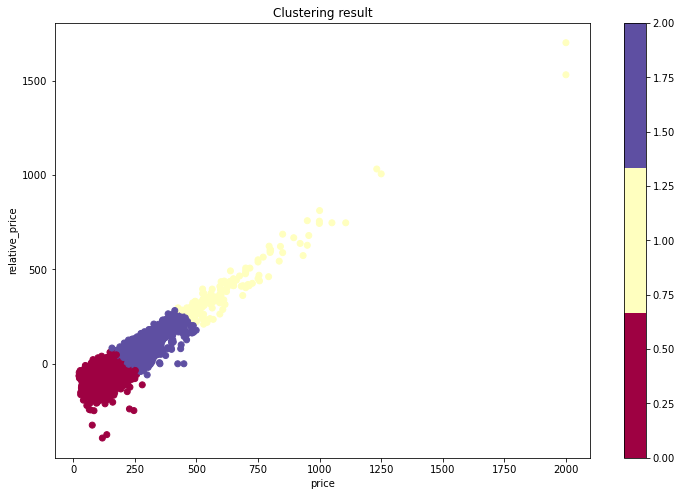

In [93]:
#价格聚类分析（划分为3档）

#read in data
seattle = spatial_analysis

#与周边房源的相对价格：房源价格-周边房源均价
seattle['relative_price'] = 0
for i in range(len(seattle['price'])):
    seattle['relative_price'] = seattle['price'] - seattle['average_price']
seattle

#when num_cluster=3, silhouette score is the highest
seattle_sub = seattle.loc[:,['price','relative_price']]
seattle_sub.columns = ['price', 'relative_price']
num_clusters = 3
random_state_seed = 100
kmeans_output = sklc.KMeans(n_clusters = num_clusters, random_state = random_state_seed).fit(seattle_sub)
clustering_ids_kmeans = kmeans_output.labels_
print(clustering_ids_kmeans) #check the clustering results
seattle_sub = seattle_sub.assign(cluster_id = clustering_ids_kmeans) #assign clustering id with the original data

#plot the result of clustering
fig, ax = plt.subplots(figsize = (12,8))
# number of clusters
n_clusters = seattle_sub.cluster_id.nunique() #cluster_id.nunique() return number of unique elements in the object
# get discrete colormap
cmap = plt.get_cmap('Spectral',n_clusters)
# scatter points
scatter = ax.scatter(seattle_sub.price, seattle_sub.relative_price, c = seattle_sub.cluster_id, cmap = cmap)
ax.set_xlabel('price')
ax.set_ylabel('relative_price')
ax.set_title('Clustering result')
# add colorbar
cbar = plt.colorbar(scatter)

#calculate the silhouette_score when num_cluster=3,4,5
silhouette_kmeans = sklm.silhouette_score(seattle_sub,clustering_ids_kmeans) #(data points,labels of clusters)
df_silhouette_score = pd.DataFrame({'n_cluster':[3,4,5], 'silhouette_score':[0,0,0]})
for index, row in df_silhouette_score.iterrows():
    n_clusters = row['n_cluster']
    clusterer = sklc.KMeans(n_clusters = n_clusters, random_state = random_state_seed).fit(seattle_sub)
    cluster_labels = clusterer.labels_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklm.silhouette_score(seattle_sub, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    row['silhouette_score'] = silhouette_avg

#合并结果
class_price = pd.concat([seattle, seattle_sub.iloc[:,2]], axis = 1)
# 2-highest price
# 1-medium price
# 0-lowest price

#导出
class_price.to_csv('class_price.csv',index = False,header = True)

Index(['host_acceptance_rate', 'accommodates', 'bathrooms', 'bedrooms',
       'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'review_scores_rating', 'response_time_num', 'type_num',
       'host_verifications_num', 'amenities_num', 'host_duration',
       'popularity', 'dist_attractions', 'dist_city', 'average_price',
       'poi_count', 'transport_count', 'cluster_id', 'host_is_superhost_t',
       'host_has_profile_pic_t', 'host_identity_verified_t',
       'instant_bookable_t', 'license_tf_t', 'host_location_tf_t'],
      dtype='object')


,host_acceptance_rate,accommodates,bathrooms,bedrooms,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,response_time_num,type_num,...,average_price,poi_count,transport_count,cluster_id,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,instant_bookable_t,license_tf_t,host_location_tf_t
host_acceptance_rate,1.000000,0.068556,0.047142,0.018060,0.030764,-0.002584,0.092407,0.027648,0.715932,0.054755,...,0.010356,0.069504,0.054925,0.046468,0.298977,-0.003927,0.038542,0.200879,0.141656,-0.051641
accommodates,0.068556,1.000000,0.632290,0.836010,0.640975,-0.103264,-0.005106,0.014504,0.088353,0.333408,...,0.219630,-0.089900,-0.075182,0.535162,-0.013795,-0.035310,-0.012677,0.063084,0.125704,-0.074452
bathrooms,0.047142,0.632290,1.000000,0.680042,0.567209,-0.050085,-0.078255,0.032631,0.031972,0.090713,...,0.153562,-0.097800,-0.080545,0.477797,-0.016501,-0.013312,-0.011809,0.022683,0.068538,-0.052805
bedrooms,0.018060,0.836010,0.680042,1.000000,0.632359,-0.083112,-0.040454,0.038859,0.029684,0.206930,...,0.183326,-0.205861,-0.176006,0.543854,-0.034702,-0.046799,-0.024457,0.008811,0.077909,-0.061138
price,0.030764,0.640975,0.567209,0.632359,1.000000,-0.033627,-0.065428,0.084644,0.078413,0.296065,...,0.393659,0.037027,0.045029,0.609390,0.022251,-0.014548,0.009032,0.029453,0.143042,-0.056082
minimum_nights_avg_ntm,-0.002584,-0.103264,-0.050085,-0.083112,-0.033627,1.000000,0.074782,-0.153247,0.011569,0.038590,...,0.002639,0.179170,0.125792,-0.048852,-0.144011,0.017742,0.049698,0.119528,-0.286325,-0.185752
maximum_nights_avg_ntm,0.092407,-0.005106,-0.078255,-0.040454,-0.065428,0.074782,1.000000,0.017292,0.075379,0.047234,...,-0.024805,0.016418,0.032460,-0.071911,0.107935,-0.017142,0.049804,0.089792,0.026807,0.063857
review_scores_rating,0.027648,0.014504,0.032631,0.038859,0.084644,-0.153247,0.017292,1.000000,0.014052,0.047055,...,0.072893,-0.110799,-0.128470,0.062401,0.309676,0.005489,-0.015677,-0.088596,0.121842,0.131930
response_time_num,0.715932,0.088353,0.031972,0.029684,0.078413,0.011569,0.075379,0.014052,1.000000,0.051425,...,0.037617,0.050153,0.018111,0.075261,0.260712,0.002097,0.017135,0.200437,0.117374,-0.070015
type_num,0.054755,0.333408,0.090713,0.206930,0.296065,0.038590,0.047234,0.047055,0.051425,1.000000,...,0.234671,0.051351,0.045896,0.217109,0.031358,0.002495,0.003274,-0.015121,0.166753,-0.043285


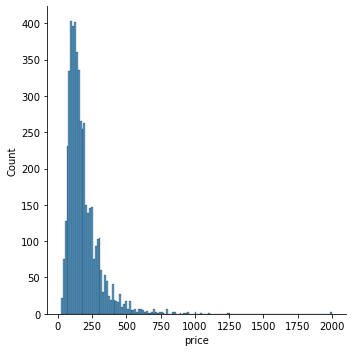

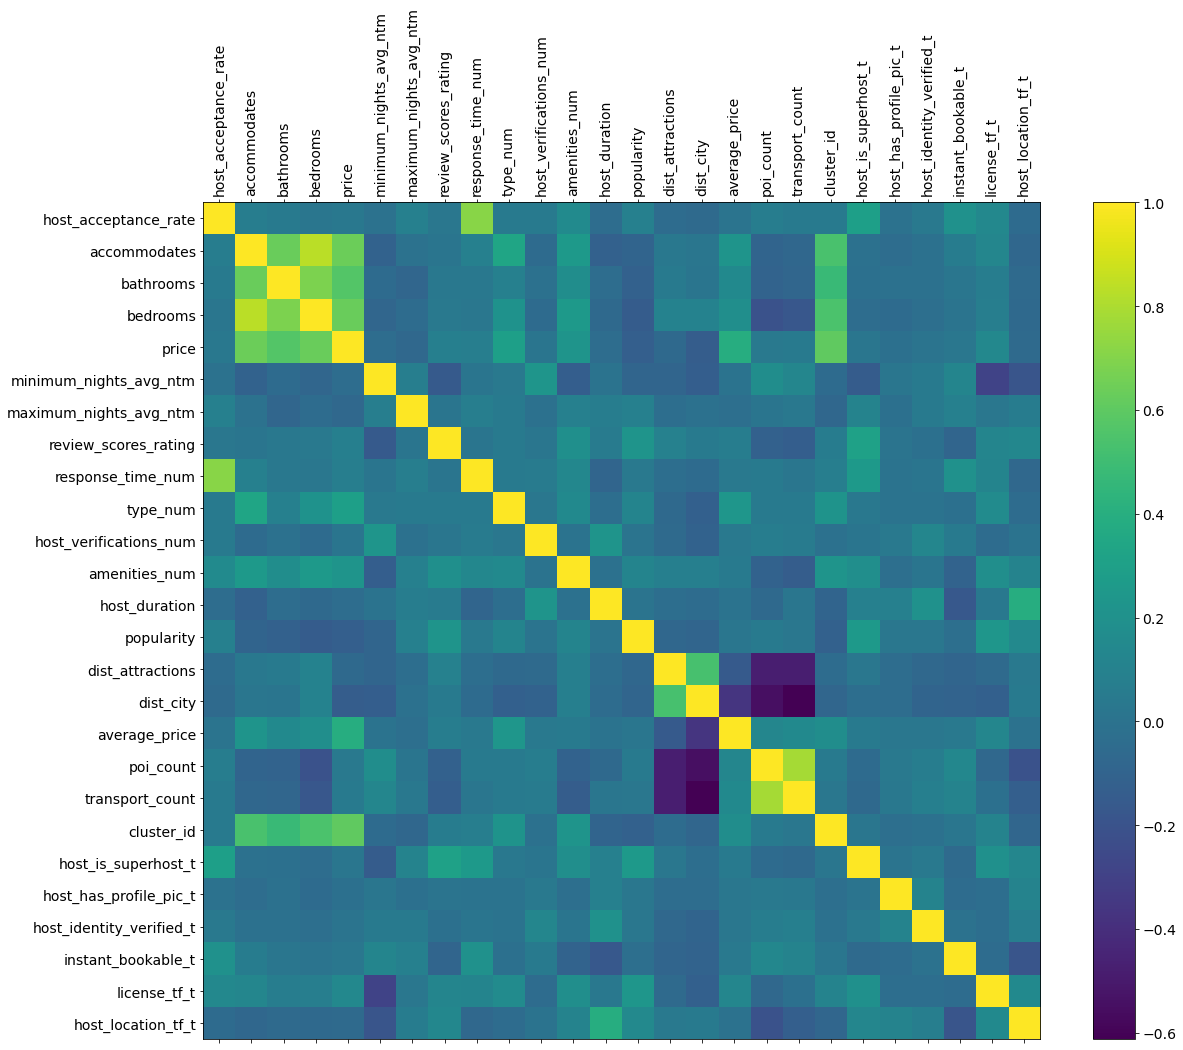

In [94]:
#VIF与相关性检验

#data preparation
seattle_dum = pd.get_dummies(class_price)
seattle = seattle_dum.drop(labels=['OID_','id','host_id','host_response_rate','calculated_host_listings_count','beds','airbnb_count','hotel_count','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value','latitude', 'longitude','relative_price','pop_past','pop_future','host_is_superhost_f','host_has_profile_pic_f','host_identity_verified_f','instant_bookable_f','license_tf_f','host_location_tf_f'], axis=1)

#def VIF
def drop_column_using_vif_(df, thresh=5):
    while True:
        df_with_const = add_constant(df)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        vif_df = vif_df.drop('const')
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break
    return df

#VIF
seattle = seattle.dropna(axis=0, how = 'any')
seattle_VIF = drop_column_using_vif_(seattle)
print(seattle_VIF.columns)

#直方图法正态性检验
sn.displot(seattle_VIF['price'])

#correlation
plt.rcParams['axes.grid'] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(seattle_VIF.corr(), fignum=f.number)
plt.xticks(range(seattle_VIF.shape[1]), seattle_VIF.columns, fontsize=14, rotation=90)
plt.yticks(range(seattle_VIF.shape[1]), seattle_VIF.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
seattle_VIF.corr()

In [95]:
#OLS
seattle_VIF_all = seattle_VIF.drop(labels=['cluster_id'], axis=1)
VIF_price = seattle_VIF_all.drop(labels=['price'], axis=1)
OLS_price = sm.OLS(endog = seattle_VIF_all[['price']], exog = sm.add_constant(VIF_price)).fit()
OLS_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     270.6
Date:                 周六, 10 12月 2022   Prob (F-statistic):               0.00
Time:                        01:54:54   Log-Likelihood:                -28679.
No. Observations:                4932   AIC:                         5.741e+04
Df Residuals:                    4907   BIC:                         5.757e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -287.6745     25.031    -11.493      0.000    -336.746    -238.603
host_acceptance_rate        -0.3604      0.065     -5.532      0.000      -0.488      -0.233
accommodates                 9.8662      0.929     10.616      0.000       8.044      11.688
bathrooms                   37.9303      2.374     15.979      0.000      33.277      42.584
bedrooms                    28.2120      2.109     13.379      0.000      24.078      32.346
minimum_nights_avg_ntm       0.0309      0.016      1.908      0.056      -0.001       0.063
maximum_nights_avg_ntm      -0.0109      0.003     -4.307      0.000      -0.016      -0.006
review_scores_rating        21.9376      3.716      5.903      0.000      14.652      29.223
response_time_num            6.9626      1.399      4.977      0.000       4.220       9.705
type_num                    30.8025      3.537      8.708      0.000      23.868      37.737
host_verifications_num       3.4389      2.795      1.231      0.219      -2.040       8.917
amenities_num                0.5242      0.098      5.368      0.000       0.333       0.716
host_duration                0.0010      0.001      0.803      0.422      -0.001       0.003
popularity                  -8.7223      0.910     -9.590      0.000     -10.505      -6.939
dist_attractions            -0.0016      0.001     -1.769      0.077      -0.003       0.000
dist_city                   -0.0006      0.000     -1.362      0.173      -0.002       0.000
average_price                0.5618      0.029     19.616      0.000       0.506       0.618
poi_count                    0.0592      0.012      4.923      0.000       0.036       0.083
transport_count              0.2966      0.192      1.545      0.122      -0.080       0.673
host_is_superhost_t          6.6100      2.681      2.465      0.014       1.353      11.867
host_has_profile_pic_t      -3.4598     12.821     -0.270      0.787     -28.595      21.675
host_identity_verified_t     2.4244      3.495      0.694      0.488      -4.428       9.276
instant_bookable_t           0.7852      2.523      0.311      0.756      -4.161       5.732
license_tf_t                15.9818      3.165      5.049      0.000       9.776      22.187
host_location_tf_t           1.1553      3.084      0.375      0.708      -4.890       7.200
==============================================================================
Omnibus:                     4942.503   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           682602.165
Skew:                           4.559   Prob(JB):                         0.00
Kurtosis:                      59.908   Cond. No.                     1.77e+05
==============================================================================

Note

host_acceptance_rate
accommodates
bathrooms
bedrooms
minimum_nights_avg_ntm
maximum_nights_avg_ntm
review_scores_rating
response_time_num
type_num
amenities_num
host_duration
popularity
dist_attractions
dist_city
average_price
poi_count
transport_count
instant_bookable_t
license_tf_t
host_location_tf_t


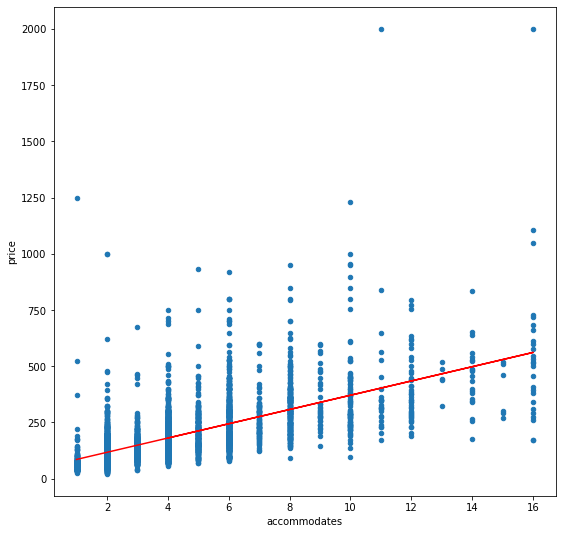

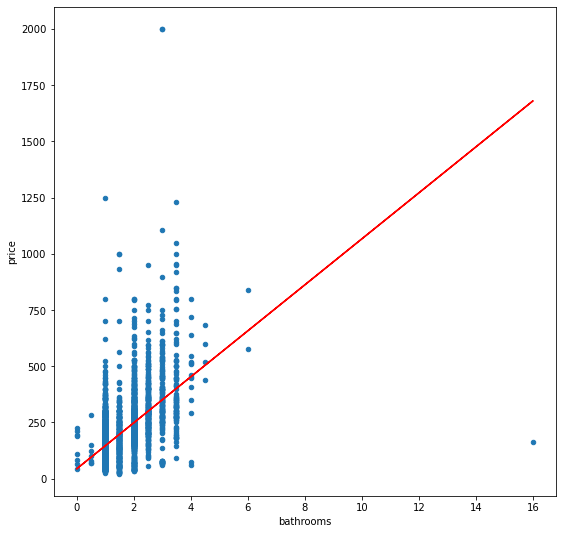

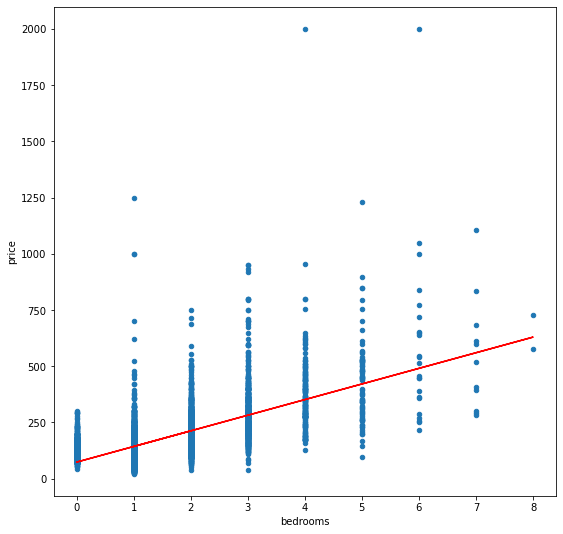

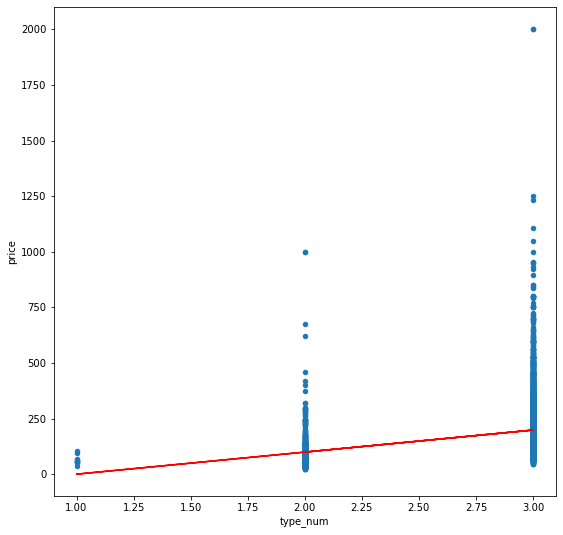

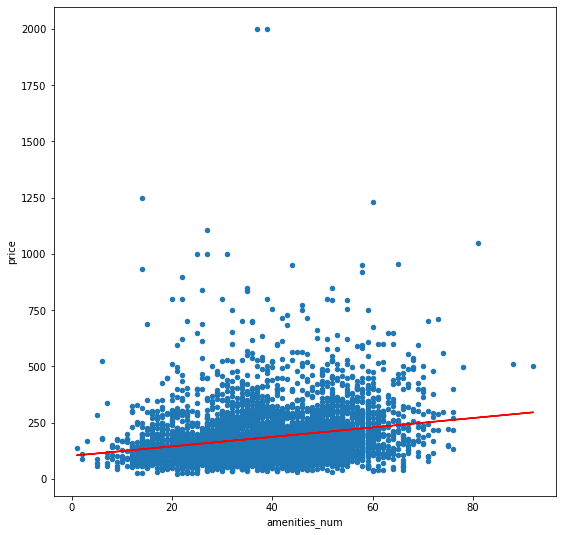

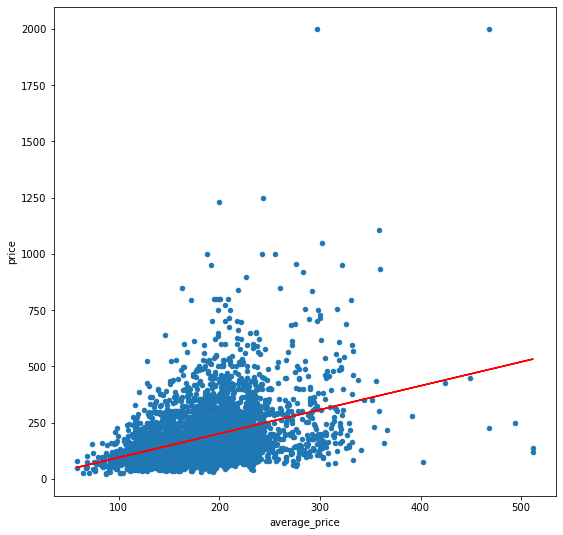

In [96]:
#输出影响显著且解释度>5%的一元线性回归图和影响显著的值
def rm(indep):
    rm = sm.OLS(endog = seattle_VIF_all[['price']], exog = sm.add_constant(VIF_price[indep])).fit()
    beta_0, beta_1 = rm.params
    rsq    = rm.rsquared
    pval_0, pval_1 = rm.pvalues
    if rsq > 0.05 and pval_1 < 0.05:
        fig, ax = plt.subplots()
        seattle_VIF_all.plot(kind='scatter', x=indep, y='price', figsize=(9, 9), ax = ax)
        X = seattle_VIF_all.eval(indep)
        b = plt.plot(X, X*beta_1 + beta_0, 'r')
    if pval_1 < 0.05:
        print(indep)

indepdent = VIF_price.columns
for i in range(len(indepdent)):
    rm(indep = indepdent[i])